In [1]:
import pandas as pd
df = pd.read_csv('data_labeled.csv', index_col='Unnamed: 0', encoding="latin1")
df.head()

date    comuna  \
0  2018-06-22 15:03:22  comuna01   
1  2018-06-22 14:54:07  comuna01   
2  2018-06-08 18:37:21  comuna01   
3  2018-06-07 20:37:10  comuna01   
4  2018-06-07 14:44:37  comuna01   

                                             message sentimiento      label  \
0  este pobre peaton pone en juego su seguridad p...    negativo    reclamo   
1  esto esta ocurriendo en la esquina de charcas ...    negativo    reclamo   
2  taller de teatro en fermin espacio cultural to...      neutro  propuesta   
3  hola querria saber como hay que hacer para asi...      neutro   consulta   
4  fijate como este sinverguenza cobra estacionam...    negativo    reclamo   

   categoria  
0  seguridad  
1  seguridad  
2    cultura  
3    cultura  
4   transito

In [2]:
df.count()

date           278
comuna         278
message        278
sentimiento    278
label          278
categoria      278
dtype: int64

In [3]:
# Separación entre train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['categoria'], test_size=0.33, random_state=42)

In [4]:
# Sólo para chequear el tamaño de la matriz de features
from sklearn.feature_extraction.text import TfidfVectorizer
m1 = TfidfVectorizer()
X_train_vec = m1.fit_transform(X_train)
X_train_vec.shape

(186, 2733)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [6]:
model.fit(X_train, y_train)
labels = model.predict(X_test)

In [7]:
labels

array(['abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl',
       'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl',
       'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'cultura', 'abl',
       'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl',
       'abl', 'abl', 'abl', 'cultura', 'abl', 'abl', 'abl', 'abl', 'abl',
       'abl', 'abl', 'abl', 'cultura', 'abl', 'abl', 'abl', 'abl', 'abl',
       'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl',
       'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl',
       'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'cultura',
       'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl', 'abl',
       'abl', 'abl'], dtype='<U18')

In [8]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, labels)

0.5

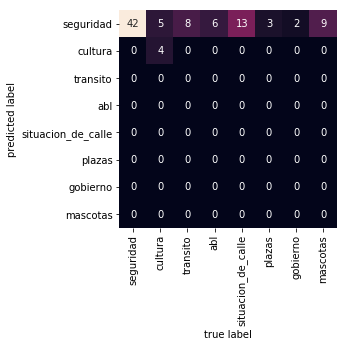

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns;
import matplotlib.pyplot as plt
%matplotlib inline


df = df[['message', 'categoria']]
df.columns = ['message', 'categoria']
df['category_id'] = df['categoria'].factorize()[0]
category_id_df = df[['categoria', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'categoria']].values)


mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=category_id_df.categoria.values, yticklabels=category_id_df.categoria.values)
plt.xlabel('true label')
plt.ylabel('predicted label');

Reducción de la dimensionalidad
¿Cuál es la relación entre la cantidad de features y la cantidad de casos de entrenamiento? De acuerdo a la maldición de la dimensionalidad esta relación es un problema.
Una de las técnicas más comunes para reducir dimensiones es utilizar "stopwords", una lista con las palabras de cada idioma que no tienen un peso semántico importante. 
Entrenen nuevamente el modelo quitando las stopwords del español que se encuentran en el archivo "stopwords.csv". 
¿Qué pasa con la cantidad de dimensiones de la matriz de features? ¿Y con el accuracy?

In [10]:
stopwords = pd.read_csv('stopwords.csv',header=None)[0]

In [11]:
from unidecode import unidecode
stopwords = stopwords.apply(unidecode) 

In [12]:
# Es importante que las stopwords se encuentren en una lista
stopwords = list(stopwords)

In [13]:
# Sólo para chequear el tamaño de la matriz de features
m1 = TfidfVectorizer(stop_words = list(stopwords))
X_train_vec = m1.fit_transform(X_train)
X_train_vec.shape

(186, 2609)

In [14]:
model = make_pipeline(TfidfVectorizer(stop_words = list(stopwords)), MultinomialNB())

In [15]:
model.fit(X_train, y_train)
labels = model.predict(X_test)

In [16]:
accuracy_score(y_test, labels)

0.5

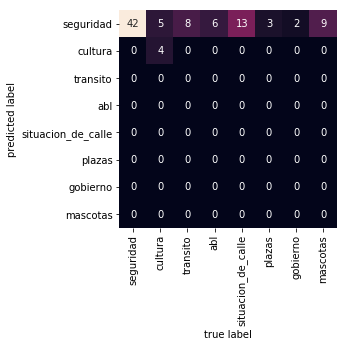

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns;
import matplotlib.pyplot as plt
%matplotlib inline
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=category_id_df.categoria.values, yticklabels=category_id_df.categoria.values)
plt.xlabel('true label')
plt.ylabel('predicted label');

Avanzando en la reducción de dimensiones
El modelo mejora cuando quitamos las stopwords pero todavía tenemos una cantidad de dimensiones demasiado alta para la cantidad de datos que tenemos.

Pensemos lo siguiente ¿Qué valor tienen las palabras que aparecen una o dos veces en todo el corpus a la hora de discriminar? Para remover del análisis las palabras que ocurren menos de determinada cantidad de veces, la clase TfidfVectorizer tiene un parámetro min_df.

Prueben setear el parámetro min_df en 6 y volver a correr el modelo. 
¿A cuánto se reduce la dimensión de la matriz de features? 
¿Cuánto mejora la performance del algoritmo?

In [18]:
model = make_pipeline(TfidfVectorizer(stop_words = list(stopwords), min_df=6), MultinomialNB())

In [19]:
model.fit(X_train, y_train)
labels = model.predict(X_test)

In [20]:
model_vec2 = TfidfVectorizer(stop_words = list(stopwords), min_df=10)

In [21]:
X_train_vec = model_vec2.fit_transform(X_train)

In [22]:
X_train_vec.shape

(186, 75)

In [23]:
accuracy_score(y_test, labels)

0.4891304347826087

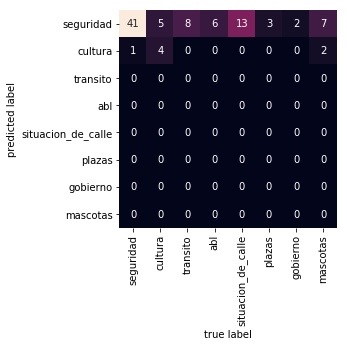

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns;
import matplotlib.pyplot as plt
%matplotlib inline
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=category_id_df.categoria.values, yticklabels=category_id_df.categoria.values)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [25]:
print(model.predict(['este fin de semana teatro para chicos en nuestra comuna']))

['abl']
